In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools#パラメータの組み合わせ用
from scipy import integrate#数値積分用
import scipy.stats #乱数用

# ベイズ推論による機械学習入門
## 第1章:ベイズの定理と機械学習
### 最小二乗法，最尤推定，ベイズ推定の比較

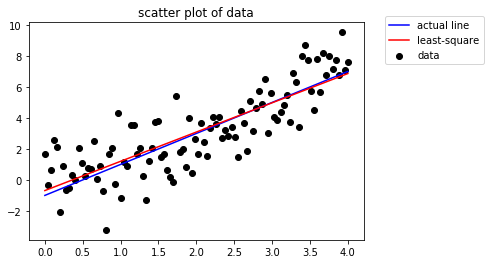

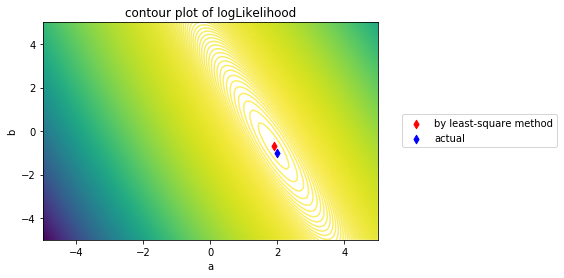

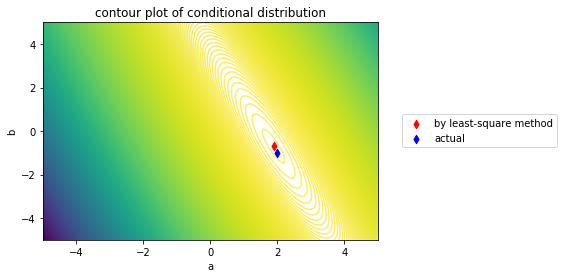

In [103]:
def bayes_and_ls():
    '''
    ベイズ推論と最小二乗法の比較.
    y = ax+b+epsilon_y に従うyを生成する．
    '''
    color_ac = 'blue'
    color_ls = 'red'
    #データ生成
    np.random.seed(0)
    num = 100
    x = np.linspace(0.0,4.0,num)
    variance_y = 1.5#yのノイズの分散
    epsilon_y = np.random.normal(0.0,variance_y,num)#yのノイズ
    params_ac = np.array([2.0,-1.0])#実際のa,b
    y = params_ac[0]*x+params_ac[1]+epsilon_y#観測されたy
    
    #最小二乗法でパラメータ推定
    params_ls = np.polyfit(x,y,1)#1次で近似
    
    #データの描画
    plt.title('scatter plot of data')
    plt.scatter(x,y,label='data',color='black')
    plt.plot(x,params_ac[0]*x+params_ac[1],label='actual line',color=color_ac)
    plt.plot(x,params_ls[0]*x+params_ls[1],label='least-square',color=color_ls)
    plt.legend(bbox_to_anchor=(1.05, 1.05))
    plt.show()
    
    #最尤推定でパラメータ推定
    a_num = 100
    b_num = 100#パラメータa,bの候補の数
    a = np.linspace(-5,5,a_num)
    b = np.linspace(-5,5,b_num)
    X,Y = np.meshgrid(a,b)
    param_product = np.array(list(itertools.product(a,b)))
    y_est = param_product@np.array([x,np.ones(num)])#y = ax+b
    y_ob = np.repeat(y,int(a_num*b_num)).reshape(num,int(a_num*b_num)).T#データのyを繰り返す．
    variance_y_est = 1.0#yのノイズの分散の推定値
    logL = (np.log(1.0/np.sqrt(2.0*np.pi*variance_y_est))-0.5*(y_ob-y_est)**2/variance_y_est).sum(axis=1)#尤度(1次元配列)
    L = logL.reshape(a_num,b_num).T#二次元に直した尤度関数
    plt.title('contour plot of logLikelihood')
    plt.contour(X,Y,L,1000,alpha=0.7)
    plt.xlabel('a')
    plt.ylabel('b')
    plt.scatter(params_ls[0],params_ls[1],label='by least-square method',marker='d',color=color_ls)
    plt.scatter(params_ac[0],params_ac[1],label='actual',marker='d',color=color_ac)
    plt.legend(bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()
    
    #ベイズの定理でパラメータ推定(尤度関数求めるところまでは共通)
    mu = np.array([1.0,-1.0])#a,bの同時分布が正規分布と仮定する．その平均
    covariance = np.array([[100.0,0.0],[0.0,100.0]])#同時分布の分散．無情報として分散を大きくとる
    p = 1.0/(2.0*np.pi*np.sqrt(np.linalg.det(covariance)))*np.exp(-0.5*(param_product-mu)@np.linalg.inv(covariance)@(param_product-mu).T)
    joint_p = np.diag(p).reshape(a_num,b_num).T
    plt.title('contour plot of conditional distribution')
    plt.contour(X,Y,L+np.log(joint_p),1000,alpha=0.7)
    plt.xlabel('a')
    plt.ylabel('b')
    plt.scatter(params_ls[0],params_ls[1],label='by least-square method',marker='d',color=color_ls)
    plt.scatter(params_ac[0],params_ac[1],label='actual',marker='d',color=color_ac)
    plt.legend(bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()
    
    
    
bayes_and_ls()

## 第2章:基本的な確率分布
### 用語
#### エントロピー

エントロピーH$=\displaystyle\int p(x)\ln p(x)$d$x$

一様分布の場合$p(x)=\begin{cases}
\displaystyle\frac{1}{b-a}(a\leq x\leq b)\\
0
\end{cases}$である.

したがってエントロピーは$-\displaystyle\frac{1}{b-a}\ln\left(\frac{1}{b-a}\right)(b-a)=\ln\left( {b-a}\right)$となる.b-aが小さいほどある種デルタ関数のようなものに近づき予測しやすくなると考えると，b-aが小さいほどエントロピーが小さくなるのは直観にかなっている．

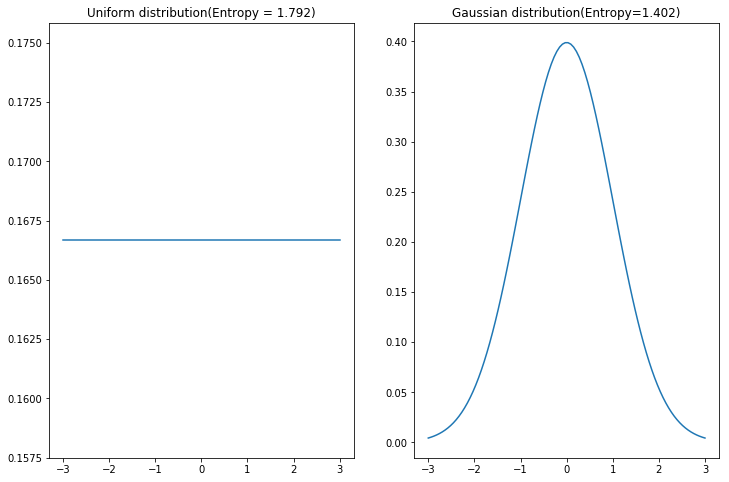

In [54]:
def plot_entropy():
    '''
    各種確率分布のプロットとエントロピー
    '''
    def uniform_entropy(x,a,b,entropy=True):
        '''
        一様分布のエントロピーを返す．
        (a,b)の区間での一様分布についてエントロピーを計算
        '''
        p = 1.0/(b-a)*np.logical_and(x>=a*np.ones(len(x)),x<=b*np.ones(len(x)))#一様分布の確率分布
        p = p[p>0]
        if entropy:
            return -p[0]*np.log(p)[0]*(b-a)#エントロピーを返す
        else:
            return p#確率密度を返す
    
    def gaussian_entropy_i(x,mu,sigma):
        '''
        正規分布の確率密度関数にlogをとったものを返す．これを積分すれば情報量になるので。
        mu:平均
        sigma:標準偏差．sqrt(variance)
        '''
        p = scipy.stats.norm.pdf(x,loc=mu,scale=sigma)#確率分布
        return -p*np.ma.log(p)
        
    def gaussian_entropy(x,mu,sigma):
        '''
        正規分布のエントロピーを返す.
        mu:平均
        sigma:標準偏差
        '''
        return scipy.integrate.quad(gaussian_entropy_i,x[0],x[-1],args=(mu,sigma))
        
    x = np.linspace(-3,3,100)
    a = -3#一様分布の左端
    b = 3#一様分布の右端
    mu = 0.0#ガウス分布の平均
    sigma = 1.0#ガウス分布の標準偏差
    
    #一様分布描画
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.title('Uniform distribution(Entropy = {})'.format(round(uniform_entropy(x,-3,3),3)))
    plt.plot(x,uniform_entropy(x,a,b,entropy=False))
    
    #正規分布描画
    plt.subplot(1,2,2)
    plt.title('Gaussian distribution(Entropy={})'.format(round(gaussian_entropy(x,mu,sigma)[0],3)))
    plt.plot(x,scipy.stats.norm.pdf(x,loc=mu,scale=sigma))
    plt.show()
    
    
plot_entropy()
